# Project 1 - part A

- Select 30 stocks in the S&P 500 universe
- Collect daily returns for the past 10 years (2014-2023)
- Create both value-weighted and equally weighted portfolio
- Rebalance these portfolios in the first day of the month based on the
information on the last day (1-day lag)
- Which portfolio has the highest turnover?
- Compute daily returns for both portfolios
- Compute the following statistics for these portfolios: annualized
average return, annualized standard deviation, Sharpe ratio,
Information Ratio (vs S&P500)
- Plot cumulative returns for both porfolios, S&P 500 and risk-free

Selected Stocks: ['DIS', 'UHS', 'GOOGL', 'LOW', 'BSX', 'JPM', 'EOG', 'SBAC', 'STT',
       'DVN', 'VRTX', 'BK', 'ALL', 'WY', 'OXY', 'ON', 'EXC', 'UAL',
       'AKAM', 'SMCI', 'LYV', 'AMD', 'VLO', 'NI', 'DRI', 'SJM', 'APH',
       'MAS', 'CMG', 'TXT']

S&P500 stock: SPY

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import yfinance as yf

tickers = [
    'DIS', 'UHS', 'GOOGL', 'LOW', 'BSX', 'JPM', 'EOG', 'SBAC', 'STT', 'DVN',
    'VRTX', 'BK', 'ALL', 'WY', 'OXY', 'ON', 'EXC', 'UAL', 'AKAM', 'SMCI',
    'LYV', 'AMD', 'VLO', 'NI', 'DRI', 'SJM', 'APH', 'MAS', 'CMG', 'TXT'
]

n_tickers = len(tickers)

start_date = '2014-01-01'
end_date = '2023-12-31'

df_bloomberg = pd.read_csv("../data/data_stocks_price.csv")

# Download the daily data from stocks
price = yf.download(tickers, start=start_date, end=end_date, progress=True)['Adj Close']
sp500_price = yf.download(["SPY"],start=start_date, end=end_date, progress=True)['Adj Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


## Daily Returns

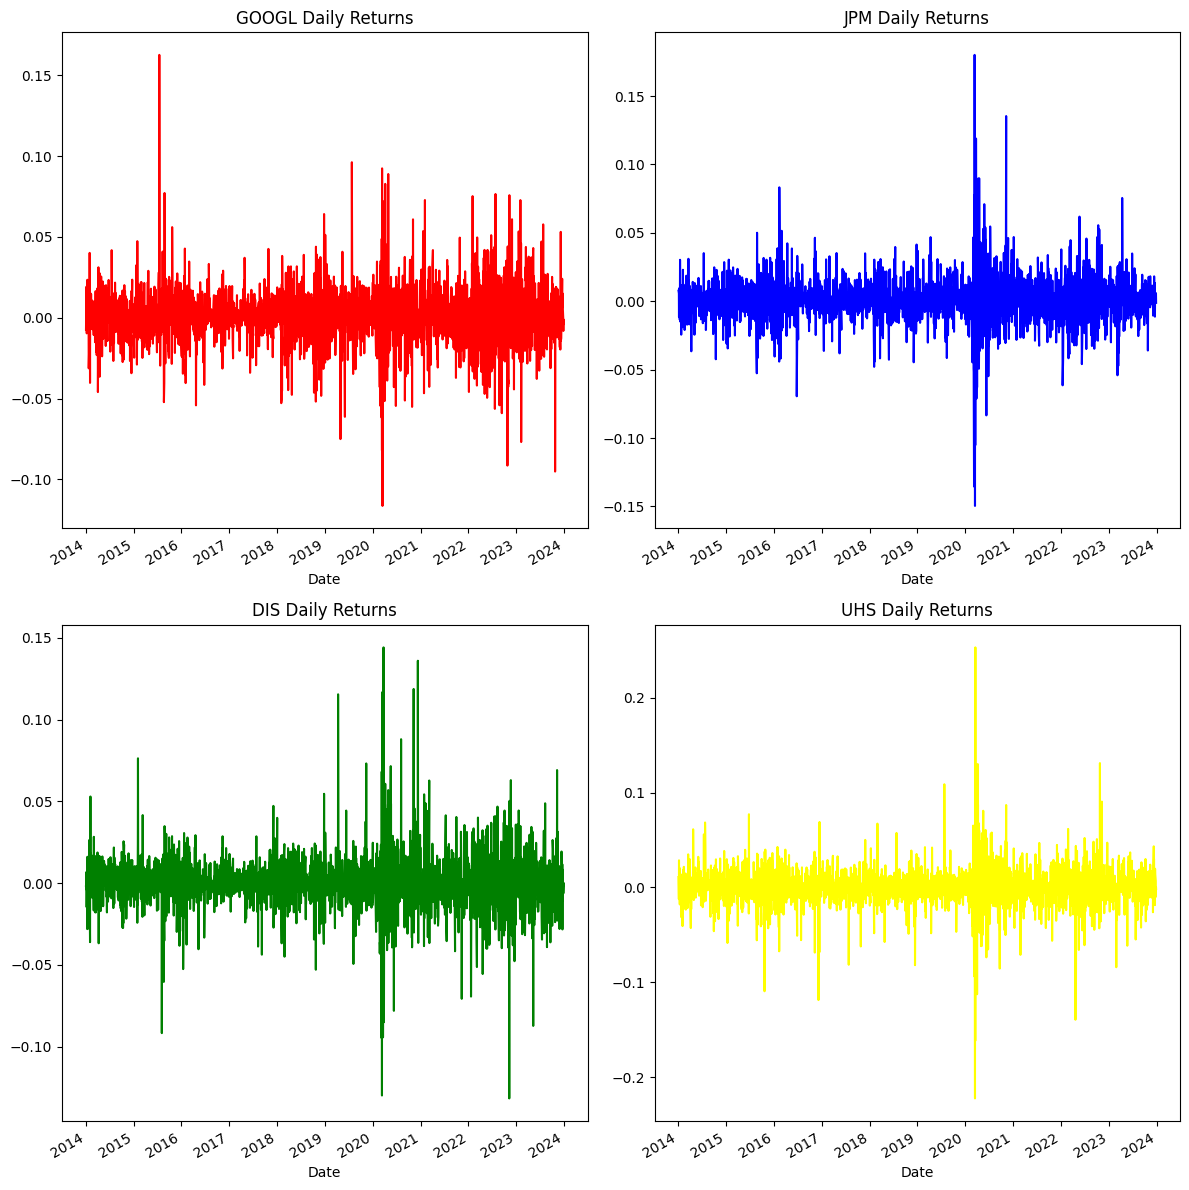

In [92]:
daily_returns_stocks = price.pct_change()
daily_returns_sp500 = sp500_price.pct_change()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

daily_returns_stocks["GOOGL"].plot(ax=ax1, title="GOOGL Daily Returns",color="red")
daily_returns_stocks["JPM"].plot(ax=ax2, title="JPM Daily Returns",color="blue")
daily_returns_stocks["DIS"].plot(ax=ax3, title="DIS Daily Returns",color="green")
daily_returns_stocks["UHS"].plot(ax=ax4, title="UHS Daily Returns",color="yellow")

fig.set_figheight(12)
fig.set_figwidth(12)

plt.tight_layout()
plt.show()


In [93]:
daily_returns_stocks.index = pd.to_datetime(daily_returns_stocks.index).tz_localize(None)

## Value-Weighted and Equally-Weighted Portfolio

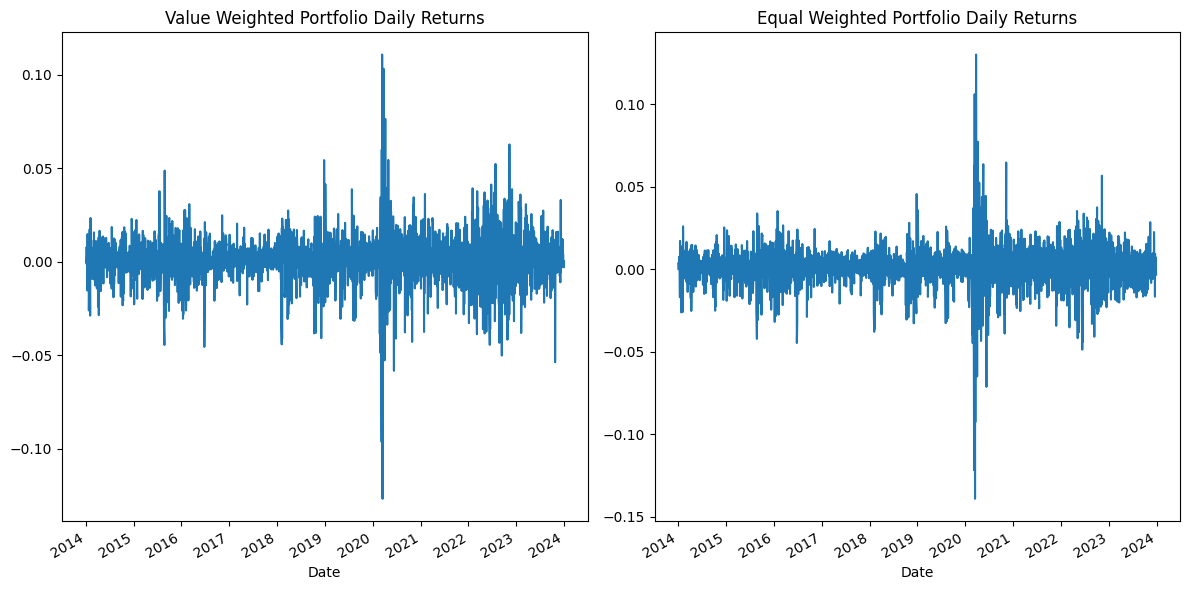

In [94]:
def value_weight_daily_returns(df,market_cap_df):
    """
        This function receives a time series with the daily returns of n stocks and the daily market cap of those stocks. Returns a time series of the value-weighted portfolio daily returns
        and another time series with the cumulative value of the portfolio.
    """

    market_cap_df.index = pd.to_datetime(market_cap_df.index)
    
    market_cap_df = market_cap_df.shift(1) # Now the value in the last day of the month will be in the first day of the month 
    
    # Get the first day of the month weights and propagate the weights to all the other days of the month
    monthly_market_cap = market_cap_df.resample("MS").first()
    normalized_monthly_market_cap = monthly_market_cap.divide(monthly_market_cap.sum(axis=1),axis=0)
    value_weights_daily = normalized_monthly_market_cap.reindex(market_cap_df.index, method="ffill")
    
    portfolio_daily_returns = (value_weights_daily*df).sum(axis=1)
    cumulative = (1+portfolio_daily_returns).cumprod()
    return cumulative, portfolio_daily_returns

def equal_weight_daily_returns(df):
    """
        This function receives a time series with the daily returns of n stocks. Returns a time series of the equal-weighted portfolio daily returns
        and another time series with the cumulative value of the portfolio.
    """
    
    equal_weights_daily = pd.Series(1 / len(df.columns), index=df.columns)
    
    portfolio_daily_returns = (equal_weights_daily*df).sum(axis=1)
    cumulative = (1+portfolio_daily_returns).cumprod()
    return cumulative, portfolio_daily_returns

CUR_MKT_CAP_df = df_bloomberg.pivot_table(index="Date",columns="Ticker",values="CUR_MKT_CAP")
VWP_cumulative, VWP_daily = value_weight_daily_returns(daily_returns_stocks,CUR_MKT_CAP_df)
EWP_cumulative, EWP_daily = equal_weight_daily_returns(daily_returns_stocks)

fig, (ax1,ax2) = plt.subplots(1,2)

VWP_daily.plot(ax=ax1, title="Value Weighted Portfolio Daily Returns")
EWP_daily.plot(ax=ax2, title="Equal Weighted Portfolio Daily Returns")

fig.set_figheight(6)
fig.set_figwidth(12)

plt.tight_layout()
plt.show()

Equal weighted protfolio have the highest turnover

### Annualized average return, Annualized standard deviation, Sharpe ratio, Information Ratio (vs S&P500)

In [95]:
rf_rate = 0.04 # Annual Risk free rate

def annualized_return(daily_returns):
    return daily_returns.mean()*252

def annualized_std(daily_returns):
    return daily_returns.std() * np.sqrt(252)

def sharpe_ratio(daily_returns,rf_rate):
    ann_return = annualized_return(daily_returns)
    ann_std = annualized_std(daily_returns)
    return (ann_return - rf_rate) / ann_std

def information_ratio(portfolio_return, benchmark_return):
    tracking_error = annualized_std(portfolio_return-benchmark_return)
    ann_portfolio_return = annualized_return(portfolio_return)
    ann_benchmark_return = annualized_return(benchmark_return)
    return (ann_portfolio_return - ann_benchmark_return) / tracking_error

dict_ports = {"Equal Weighted Portfolio":EWP_daily,"Value Weighted Portfolio":VWP_daily}
for name,daily_returns in dict_ports.items():
    print(name)
    print(f"Annualized Average Return: {annualized_return(daily_returns):.4f}")
    print(f"Annualized Standard Deviation: {annualized_std(daily_returns):.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio(daily_returns,rf_rate):.4f}")
    print(f"Information Ratio: {information_ratio(daily_returns,daily_returns_sp500):.4f}")
    print()

Equal Weighted Portfolio
Annualized Average Return: 0.1820
Annualized Standard Deviation: 0.2103
Sharpe Ratio: 0.6752
Information Ratio: 0.6345

Value Weighted Portfolio
Annualized Average Return: 0.1566
Annualized Standard Deviation: 0.2119
Sharpe Ratio: 0.5502
Information Ratio: 0.3417



### Cumulative returns for both porfolios, S&P 500 and risk-free

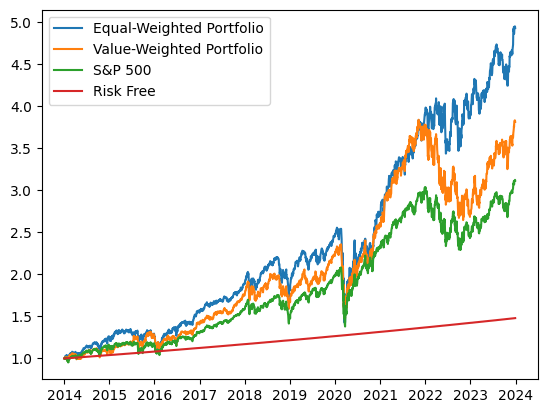

In [120]:
SP500_cumulative = (1+daily_returns_sp500).cumprod()
daily_rf_rate = pd.Series(data=(1 + rf_rate) ** (1/252) - 1,index=SP500_cumulative.index)
rf_rate_cumulative = (1+daily_rf_rate).cumprod()
plt.plot(EWP_cumulative, label="Equal-Weighted Portfolio")
plt.plot(VWP_cumulative, label="Value-Weighted Portfolio")
plt.plot(SP500_cumulative, label="S&P 500")
plt.plot(rf_rate_cumulative, label="Risk Free")
plt.legend()
plt.show()